# Coursera Capstone Project

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Download and view the dataframe

In [2]:
df = pd.read_csv('Negros_Occidental_Cities.csv')
df.head()

,City,Latitude,Longitude
0,BACOLOD,10.6762,122.9513
1,BAGO,10.5389,122.8366
2,CADIZ,10.9545,123.3058
3,ESCALANTE,10.8412,123.4992
4,HIMAMAYLAN,10.1000,122.8700


### Prepare the Foursquare API

In [3]:
CLIENT_ID = 'SRY4YYNBNUUJXB1WRUTWBJ4DZMFB5LMIGLFCFNUGGF1GU34G' # your Foursquare ID
CLIENT_SECRET = '1IS2NFWWIPW55GR3NPAHDGK1M0MLESS1AH11K11103ICTJ1J' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SRY4YYNBNUUJXB1WRUTWBJ4DZMFB5LMIGLFCFNUGGF1GU34G
CLIENT_SECRET:1IS2NFWWIPW55GR3NPAHDGK1M0MLESS1AH11K11103ICTJ1J


### Let's get the cities of Negros Occidental

In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
negros_cities = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


BACOLOD
BAGO
CADIZ
ESCALANTE
HIMAMAYLAN
KABANKALAN
LA CARLOTA
SAGAY
SAN CARLOS
SILAY
TALISAY
SIPALAY
VICTORIAS


In [15]:
negros_cities.columns = ['City', 'City Latitude', 'City Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

In [16]:
negros_cities.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BACOLOD,10.6762,122.9513,Felicia’s Pastry Cafe and Steak Room,10.675129,122.953863,Café
1,BACOLOD,10.6762,122.9513,Dunkin Donuts,10.675616,122.952905,Donut Shop
2,BACOLOD,10.6762,122.9513,Diotay Eatery,10.678972,122.951722,Filipino Restaurant
3,BACOLOD,10.6762,122.9513,KFC,10.674857,122.952572,Fast Food Restaurant
4,BACOLOD,10.6762,122.9513,Negros Museum,10.674959,122.950192,History Museum


### Get the top 5 venues per city

In [17]:
# one hot encoding# one hot 
negros_onehot = pd.get_dummies(negros_cities[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
negros_onehot['City'] = negros_cities['City'] 

# move neighborhood column to the first column
fixed_columns = [negros_onehot.columns[-1]] + list(negros_onehot.columns[:-1])
negros_onehot = negros_onehot[fixed_columns]

In [19]:
negros_grouped = negros_onehot.groupby('City').mean().reset_index()

In [20]:
num_top_venues = 5

for hood in negros_grouped['City']:
    print("----"+hood+"----")
    temp = negros_grouped[negros_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----BACOLOD----
                  venue  freq
0                 Hotel  0.12
1  Fast Food Restaurant  0.09
2    Seafood Restaurant  0.09
3                  Café  0.06
4    Chinese Restaurant  0.06


----BAGO----
                  venue  freq
0           Gas Station   0.2
1                Market   0.2
2  Fast Food Restaurant   0.2
3                  Café   0.2
4        Farmers Market   0.2


----CADIZ----
                 venue  freq
0          Supermarket   0.2
1                 Café   0.2
2            BBQ Joint   0.2
3  Filipino Restaurant   0.2
4    Convenience Store   0.2


----ESCALANTE----
                     venue  freq
0        Convenience Store  0.25
1  Fruit & Vegetable Store  0.25
2                Cafeteria  0.25
3                 Pharmacy  0.25
4                     Park  0.00


----HIMAMAYLAN----
                  venue  freq
0                 Beach  0.33
1           Bus Station  0.33
2  Fast Food Restaurant  0.33
3   Austrian Restaurant  0.00
4                  Park  0.00


### Most common venues per city

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [22]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
negros_cities_sorted = pd.DataFrame(columns=columns)
negros_cities_sorted['City'] = negros_grouped['City']

for ind in np.arange(negros_grouped.shape[0]):
    negros_cities_sorted.iloc[ind, 1:] = return_most_common_venues(negros_grouped.iloc[ind, :], num_top_venues)

negros_cities_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BACOLOD,Hotel,Fast Food Restaurant,Seafood Restaurant,Japanese Restaurant,Filipino Restaurant,Chinese Restaurant,Café,History Museum,Coffee Shop,Spa
1,BAGO,Gas Station,Fast Food Restaurant,Farmers Market,Market,Café,Coffee Shop,Filipino Restaurant,Donut Shop,Diner,Department Store
2,CADIZ,Supermarket,Convenience Store,BBQ Joint,Filipino Restaurant,Café,Flea Market,Fast Food Restaurant,Farmers Market,Donut Shop,Diner
3,ESCALANTE,Pharmacy,Cafeteria,Fruit & Vegetable Store,Convenience Store,Supermarket,Coffee Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Donut Shop
4,HIMAMAYLAN,Fast Food Restaurant,Beach,Bus Station,Supermarket,Convenience Store,Flea Market,Filipino Restaurant,Farmers Market,Donut Shop,Diner


### Cluster the cities using K-means algorithm

In [24]:
kclusters = 5

negros_grouped_clustering = negros_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(negros_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 2, 2, 3, 0, 2, 2, 1, 2, 2], dtype=int32)

In [25]:
# add clustering labels
negros_cities_sorted.insert(0, 'Cluster', kmeans.labels_)

negros_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
negros_merged = negros_merged.join(negros_cities_sorted.set_index('City'), on='City')

negros_merged.head() # check the last columns!

,City,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BACOLOD,10.6762,122.9513,2,Hotel,Fast Food Restaurant,Seafood Restaurant,Japanese Restaurant,Filipino Restaurant,Chinese Restaurant,Café,History Museum,Coffee Shop,Spa
1,BAGO,10.5389,122.8366,2,Gas Station,Fast Food Restaurant,Farmers Market,Market,Café,Coffee Shop,Filipino Restaurant,Donut Shop,Diner,Department Store
2,CADIZ,10.9545,123.3058,2,Supermarket,Convenience Store,BBQ Joint,Filipino Restaurant,Café,Flea Market,Fast Food Restaurant,Farmers Market,Donut Shop,Diner
3,ESCALANTE,10.8412,123.4992,3,Pharmacy,Cafeteria,Fruit & Vegetable Store,Convenience Store,Supermarket,Coffee Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Donut Shop
4,HIMAMAYLAN,10.1000,122.8700,0,Fast Food Restaurant,Beach,Bus Station,Supermarket,Convenience Store,Flea Market,Filipino Restaurant,Farmers Market,Donut Shop,Diner


### Map each city

In [28]:
# create map
map_cities = folium.Map(location=[10.6762, 122.9513], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(negros_merged['Latitude'], negros_merged['Longitude'], negros_merged['City'], negros_merged['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_cities)
       
map_cities

### Gain insight from city clusters

In [29]:
negros_merged.loc[negros_merged['Cluster'] == 0, negros_merged.columns[[0] + list(range(5, negros_merged.shape[1]))]]

,City,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,HIMAMAYLAN,Beach,Bus Station,Supermarket,Convenience Store,Flea Market,Filipino Restaurant,Farmers Market,Donut Shop,Diner
11,SIPALAY,Filipino Restaurant,Hotel,Hotel Pool,Supermarket,Convenience Store,Fast Food Restaurant,Farmers Market,Donut Shop,Diner


In [30]:
negros_merged.loc[negros_merged['Cluster'] == 1, negros_merged.columns[[0] + list(range(5, negros_merged.shape[1]))]]

,City,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,SAGAY,BBQ Joint,Bakery,Pizza Place,Hotel,Coffee Shop,Convenience Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market


In [31]:
negros_merged.loc[negros_merged['Cluster'] == 2, negros_merged.columns[[0] + list(range(5, negros_merged.shape[1]))]]

,City,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BACOLOD,Fast Food Restaurant,Seafood Restaurant,Japanese Restaurant,Filipino Restaurant,Chinese Restaurant,Café,History Museum,Coffee Shop,Spa
1,BAGO,Fast Food Restaurant,Farmers Market,Market,Café,Coffee Shop,Filipino Restaurant,Donut Shop,Diner,Department Store
2,CADIZ,Convenience Store,BBQ Joint,Filipino Restaurant,Café,Flea Market,Fast Food Restaurant,Farmers Market,Donut Shop,Diner
5,KABANKALAN,Pharmacy,Fast Food Restaurant,Diner,Flea Market,Beach,Bed & Breakfast,Bus Station,Bar,Cafeteria
6,LA CARLOTA,Fast Food Restaurant,Restaurant,Park,Convenience Store,Coffee Shop,Chinese Restaurant,Filipino Restaurant,Farmers Market,Donut Shop
8,SAN CARLOS,Market,Shopping Mall,Fast Food Restaurant,Department Store,Hotel,Supermarket,Farmers Market,Donut Shop,Diner
9,SILAY,Shopping Mall,Bakery,Donut Shop,Diner,Historic Site,Park,Other Great Outdoors,New American Restaurant,Filipino Restaurant


In [32]:
negros_merged.loc[negros_merged['Cluster'] == 3, negros_merged.columns[[0] + list(range(5, negros_merged.shape[1]))]]

,City,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,ESCALANTE,Cafeteria,Fruit & Vegetable Store,Convenience Store,Supermarket,Coffee Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Donut Shop
10,TALISAY,Flea Market,Plaza,Market,Coffee Shop,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Donut Shop,Diner


In [33]:
negros_merged.loc[negros_merged['Cluster'] == 4, negros_merged.columns[[0] + list(range(5, negros_merged.shape[1]))]]

,City,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,VICTORIAS,Donut Shop,Supermarket,Chinese Restaurant,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Diner,Department Store,Convenience Store


### Create a bar chart to visualize the city who has the most number of venues

In [35]:
cityVenues_count = negros_cities.groupby('City').count()

In [37]:
cityVenues_count_plot = cityVenues_count['Venue']

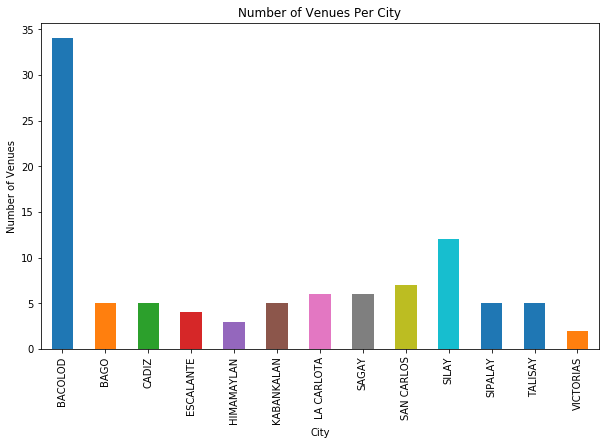

In [39]:
import matplotlib

cityVenues_count_plot.plot(kind='bar', figsize=(10, 6))

plt.xlabel('City') # add to x-label to the plot
plt.ylabel('Number of Venues') # add y-label to the plot
plt.title('Number of Venues Per City') # add title to the plot

plt.show()

### Create a pie chart to visualize the contribution of each venue to the total count

In [ ]:
bacolod_count_venues = negros_cities[:34]

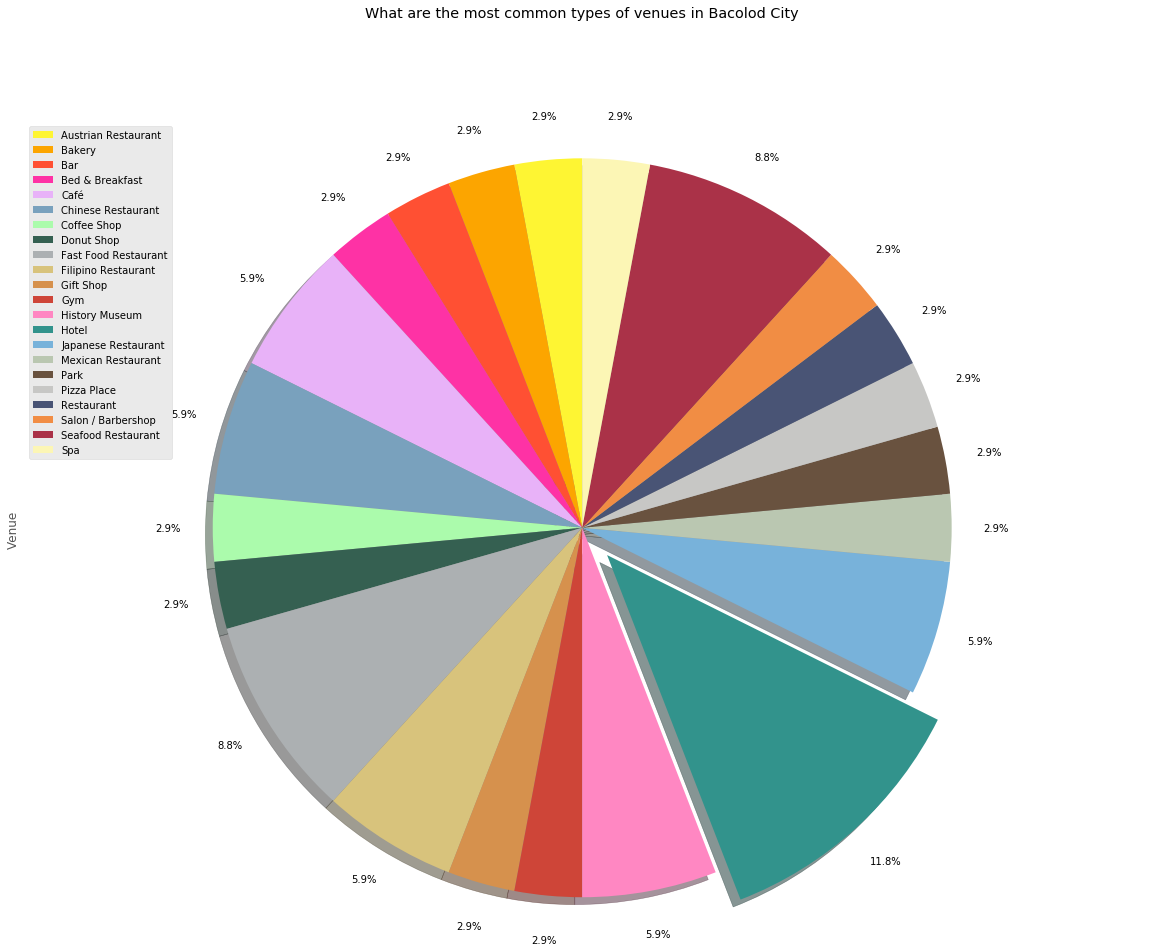

In [289]:
colors_list = ['#FEF533', '#FCA500', '#FF5033', '#FE32A5', '#E8B2F8', '#79A1BD','#ABFBAC', '#356051', '#ACB0B2', '#D8C37C', '#D6914D', '#CE4538',
               '#FF87C2', '#32938C', '#78B2DA', '#BAC7B1', '#69523F', '#C7C7C5','#495475', '#F18D44', '#AA3248', '#FCF6B5']
explode_list = [0, 0, 0, 0, 0, 0,0, 0, 0, 0, 0, 0,0,0.1,0, 0, 0, 0, 0, 0,0, 0] # ratio for each continent with which to offset each wedge.

bacolod_count_venues['Venue'].plot(kind='pie',
                            figsize=(20, 15),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' most common venue 
                            )

# scale the title up by 12% to match pctdistance
plt.title('What are the most common types of venues in Bacolod City', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=bacolod_venues_count.index, loc='upper left') 

plt.show()

### Create a word cloud from the article

In [114]:
# install wordcloud
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Wordcloud is installed and imported!


In [139]:
# open the file and read it into a variable Bacolod
Bacolod = open('Negros.txt', 'r').read()
print ('File downloaded and saved!')

File downloaded and saved!


In [142]:
# instantiate a word cloud object
stopwords = set(STOPWORDS)

bacolod_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# generate the word cloud
bacolod_wc.generate(Bacolod)

In [179]:
# save mask to bacolod_mask
from PIL import Image # converting images into arrays
bacolod_mask = np.array(Image.open('bacolod-city-map.png'))
    
print('Image downloaded and saved!')

Image downloaded and saved!


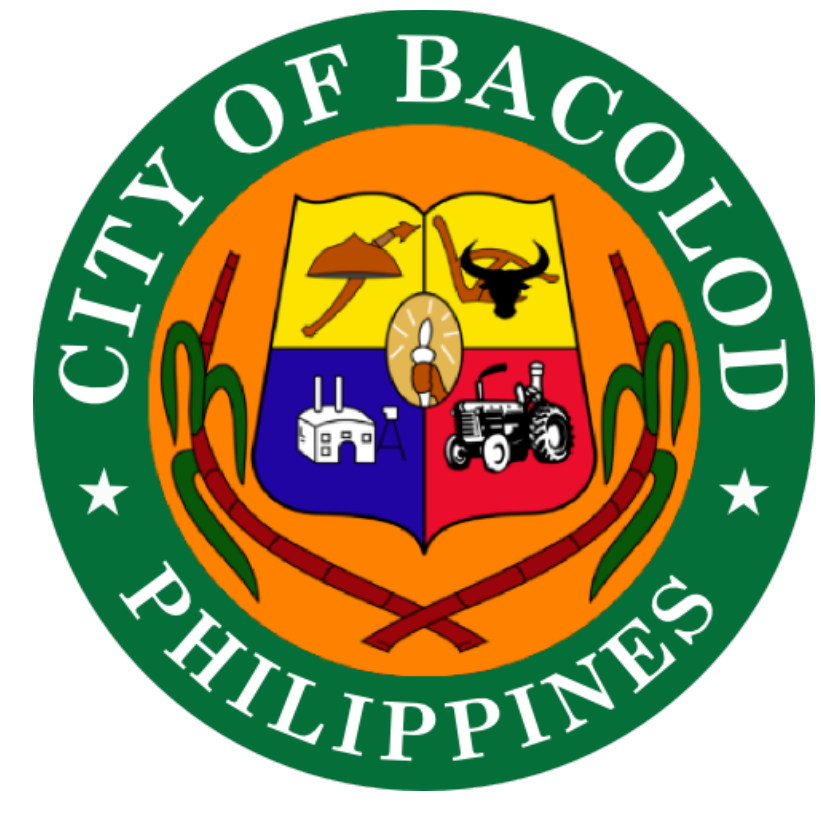

In [180]:
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(bacolod_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show() 

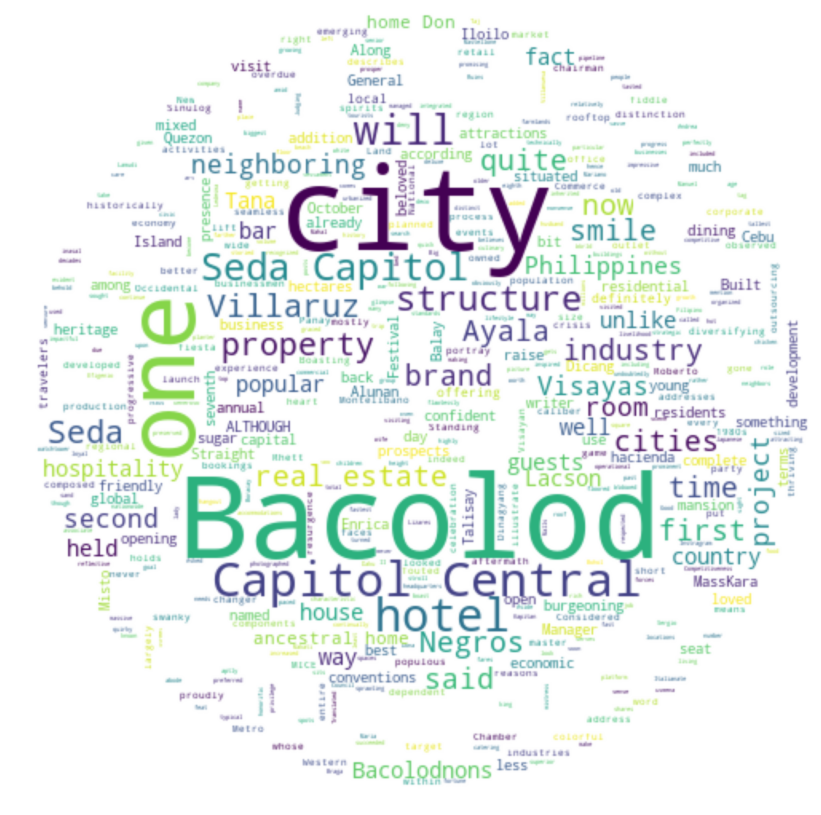

In [181]:
# instantiate a word cloud object
bacolod_wc = WordCloud(background_color='white', max_words=2000, mask=bacolod_mask, stopwords=stopwords)

# generate the word cloud
bacolod_wc.generate(Bacolod_City_Article)

# display the word cloud
fig = plt.figure()
fig.set_figwidth(14) # set width
fig.set_figheight(18) # set height

plt.imshow(bacolod_wc, interpolation='gaussian')
plt.axis('off')
plt.show()

### Plotting locations of venues using folium

In [55]:
bacolod_venues_map = negros_cities[:34]

In [57]:
bacolod_venues_map.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BACOLOD,10.6762,122.9513,Felicia’s Pastry Cafe and Steak Room,10.675129,122.953863,Café
1,BACOLOD,10.6762,122.9513,Dunkin Donuts,10.675616,122.952905,Donut Shop
2,BACOLOD,10.6762,122.9513,Diotay Eatery,10.678972,122.951722,Filipino Restaurant
3,BACOLOD,10.6762,122.9513,KFC,10.674857,122.952572,Fast Food Restaurant
4,BACOLOD,10.6762,122.9513,Negros Museum,10.674959,122.950192,History Museum


In [ ]:
#retain only venues coords for folium
bacolod_venues_map = bacolod_venues_map.drop(['City','City Latitude','City Longitude'], axis = 1)

In [60]:
bacolod_venues_map.head()

,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Felicia’s Pastry Cafe and Steak Room,10.675129,122.953863,Café
1,Dunkin Donuts,10.675616,122.952905,Donut Shop
2,Diotay Eatery,10.678972,122.951722,Filipino Restaurant
3,KFC,10.674857,122.952572,Fast Food Restaurant
4,Negros Museum,10.674959,122.950192,History Museum


### Genereate ids for each venue

In [ ]:
#convert 'Venue Category' column to list
bacolod_venues_list = bacolod_venues_map['Venue Category'].tolist()

In [ ]:
#initialize blank list
cat_key = []

#arbitrarily assign keys to each category
for i in range(len(bacolod_venues_list)):
               if(bacolod_venues_list[i] == 'Austrian Restaurant'):
                    cat_key.append(0)
               elif(bacolod_venues_list[i] == 'Bakery'):
                    cat_key.append(1)
               elif(bacolod_venues_list[i] == 'Bar'):
                    cat_key.append(2)
               elif(bacolod_venues_list[i] == 'Bed & Breakfast'):
                    cat_key.append(3)
               elif(bacolod_venues_list[i] == 'Café'):
                    cat_key.append(4)
               elif(bacolod_venues_list[i] == 'Chinese Restaurant'):
                    cat_key.append(5)
               elif(bacolod_venues_list[i] == 'Coffee Shop'):
                    cat_key.append(6)
               elif(bacolod_venues_list[i] == 'Donut Shop'):
                    cat_key.append(7)
               elif(bacolod_venues_list[i] == 'Fast Food Restaurant'):
                    cat_key.append(8)
               elif(bacolod_venues_list[i] == 'Filipino Restaurant'):
                    cat_key.append(9)
               elif(bacolod_venues_list[i] == 'Gift Shop'):
                    cat_key.append(10)
               elif(bacolod_venues_list[i] == 'Gym'):
                    cat_key.append(11)
               elif(bacolod_venues_list[i] == 'History Museum'):
                    cat_key.append(12)
               elif(bacolod_venues_list[i] == 'Hotel'):
                    cat_key.append(13)
               elif(bacolod_venues_list[i] == 'Japanese Restaurant'):
                    cat_key.append(14)
               elif(bacolod_venues_list[i] == 'Mexican Restaurant'):
                    cat_key.append(15)
               elif(bacolod_venues_list[i] == 'Park'):
                    cat_key.append(16)
               elif(bacolod_venues_list[i] == 'Pizza Place'):
                    cat_key.append(17)
               elif(bacolod_venues_list[i] == 'Restaurant'):
                    cat_key.append(18)
               elif(bacolod_venues_list[i] == 'Seafood Restaurant'):
                    cat_key.append(19)
               elif(bacolod_venues_list[i] == 'Salon / Barbershop'):
                    cat_key.append(20)
               elif(bacolod_venues_list[i] == 'Spa'):
                    cat_key.append(21)


In [ ]:
#convert generated keys back to a column and label it id
df1 = pd.DataFrame({'id': cat_key})

In [ ]:
#merge the generated ids to the original dataframe
bacolod_venues_map = pd.concat([bacolod_venues_map, df1], axis=1)

In [288]:
# create map
#due to folium's limiatation I decided to set the color of the markers to orange
map_venues = folium.Map(location=[10.6762, 122.9513], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bacolod_venues_map['Venue Latitude'], bacolod_venues_map['Venue Longitude'], bacolod_venues_map['Venue'], bacolod_venues_map['id']):
    label = folium.Popup(str(poi) + ' id ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color= 'orange',
        fill_opacity=0.7).add_to(map_venues)
       
map_venues